# scGraphDiffusion

In [ ]:
# Loading Packages
import func.info_log as info_log
info_log.print('\n> Loading Packages')
import torch
from time import time

# Local modules
import scData.load as load
import scAnalysis.preprocess as preprocess
from GND.graph_DIF import graph_diffusion
from scAnalysis.clustering import kmeans, louvain, leiden, record_cluster, clustering, evaluate_clustering

from scData.scdata_metrics import SCData
from scData.scdata_visualization import umap_view, trajectory_view, similarity_view, diffusion_view, clustering_comparation_view, gnd_view
from scData.scdata_exporting import export_data
from scGraph.build_graph import build_graph, build_gnd_graph
from scGraph.modify_graph import modify_graph
from scGraph.call_attention import call_attention, call_gnd_attention
from scGraph.call_modularity import call_modularity, call_gnd_modularity, view_gnd_modularity
from scAnalysis.build_trajectory import build_trajectory
from func.umap_embedding import umap_embedding, special_umap_embedding, diffusion_umap_embedding, diffusion_ML_embedding

2023-11-01 15:35:56,955 - 
> Loading Packages


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
print(torch.cuda.get_device_name())

cuda
Tesla V100-PCIE-16GB


In [5]:
DATA_PATH = 'data/Klein/outputs/'
DATA_TYPE = '10X'
OUTPUT_PATH = 'outputs/klein/'

## Loading data and preprocessing 

In [5]:
# Load
info_log.print('\n> Loading data ...')


scdata = load.load_10X_data(DATA_PATH, is_cell_by_gene=True, is_genes=False)


2023-10-05 20:32:45,046 - 
> Loading data ...
2023-10-05 20:32:45,047 - --------> Loading from 10X data ...
2023-10-05 20:33:22,576 - ----------------> Matrix has 2717 cells and 24175 genes


In [6]:
#export_data(scdata, data=['10X_data'], output_path=OUTPUT_PATH, add_folder=True)

2023-10-01 13:37:12,730 - 
> Preprocessing data ...
2023-10-01 13:37:12,731 - ---------> Log-transforming data ...
2023-10-01 13:37:14,115 - ---------> Sorting and selecting top genes ...


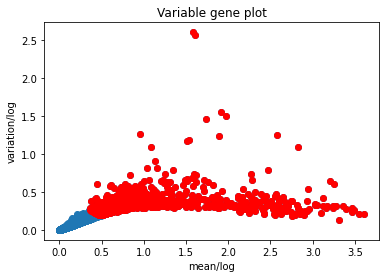

In [5]:
# Preprocessing(pp)
info_log.print('\n> Preprocessing data ...')


# pp method 1
#scdata = preprocess.percentile_filter(scdata, cell_cutoff=10, gene_cutoff=10)

#scdata = preprocess.key_filter(scdata, gene_key=None, cell_key=None)


scdata = preprocess.log_transform(scdata, data_type = "raw", log=True, scale=True, scale_factor=10000)

scdata = preprocess.varibale_gene_select(scdata, data_type="raw.log", num_select=2000)

#print(scdata.svg.expr.shape)

## Diffusion process

In [98]:
# Build graph

scdata = build_graph(scdata, k=50, data_type="svg", graph_name='dif_graph', self_edge = False, prune=True)

print(scdata.dif_graph.edge_index.size())

torch.Size([2, 135641])


In [99]:
scdata = graph_diffusion(scdata, D_out=2000, data_type='svg', use_graph='dif_graph', recover_adj_name='raw_graph',
                      max_epoch=2000, lr=5e-4, device=device,
                           num_features_diffusion=50,
                           num_heads_diffusion=6,
                           num_steps_diffusion=8, 
                           time_increment_diffusion=0.05,
                           attention_type = 'sum', 
                           activation=torch.nn.ELU(),
                           dropout=0.0, 
                           log_attention=False, 
                           log_diffusion=True,
                           encoder=[300], 
                           decoder=[300],
                           save_model = True,
                           load_model_state = False,
                           loss_adj=0.0,
                           rebuild_graph=True,
                           k=50)
scdata.save(OUTPUT_PATH+"scdata.pickle")




2023-10-06 13:29:58,371 - --------> Starting Graph AE ...
/projectnb/czproj/Algorithms/ycliu/scGraphDiffusion/auto_encoders/graph_DIF.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_1 = torch.tensor(adj_graph.adj.to(device), dtype = recon_adj.dtype)
/projectnb/czproj/Algorithms/ycliu/scGraphDiffusion/auto_encoders/graph_DIF.py:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_2 = torch.tensor(feature_matrix.to(device), dtype = out_nodes_features.dtype)
2023-10-06 13:30:01,815 - ------------------------> Epoch: 1/2000, Current loss: 7514373.0000
2023-10-06 13:30:04,024 - ------------------------> Epoch: 51/2000, Current loss: 1540975.7500
2023-10-06 13:30:06,204 - ---

In [5]:
scdata = SCData.load(OUTPUT_PATH+"scdata.pickle")

## Check scdata

In [24]:
# scdata.print_data()

## View UMAP of diffusion data

In [100]:
# Rebuild graph
scdata = build_graph(scdata, k=10, data_type="gae", graph_name='graph', self_edge = False, prune=True)

In [101]:
scdata = umap_embedding(scdata, data = 'gae.output', umap_args = {'n_neighbors': 5,
                                'min_dist': 0.7,
                                'metric': 'correlation',
                                'random_state': 2021})
scdata = umap_embedding(scdata, data = 'gae.input', umap_args = {'n_neighbors': 5,
                                'min_dist': 0.7,
                                'metric': 'correlation',
                                'random_state': 2021})

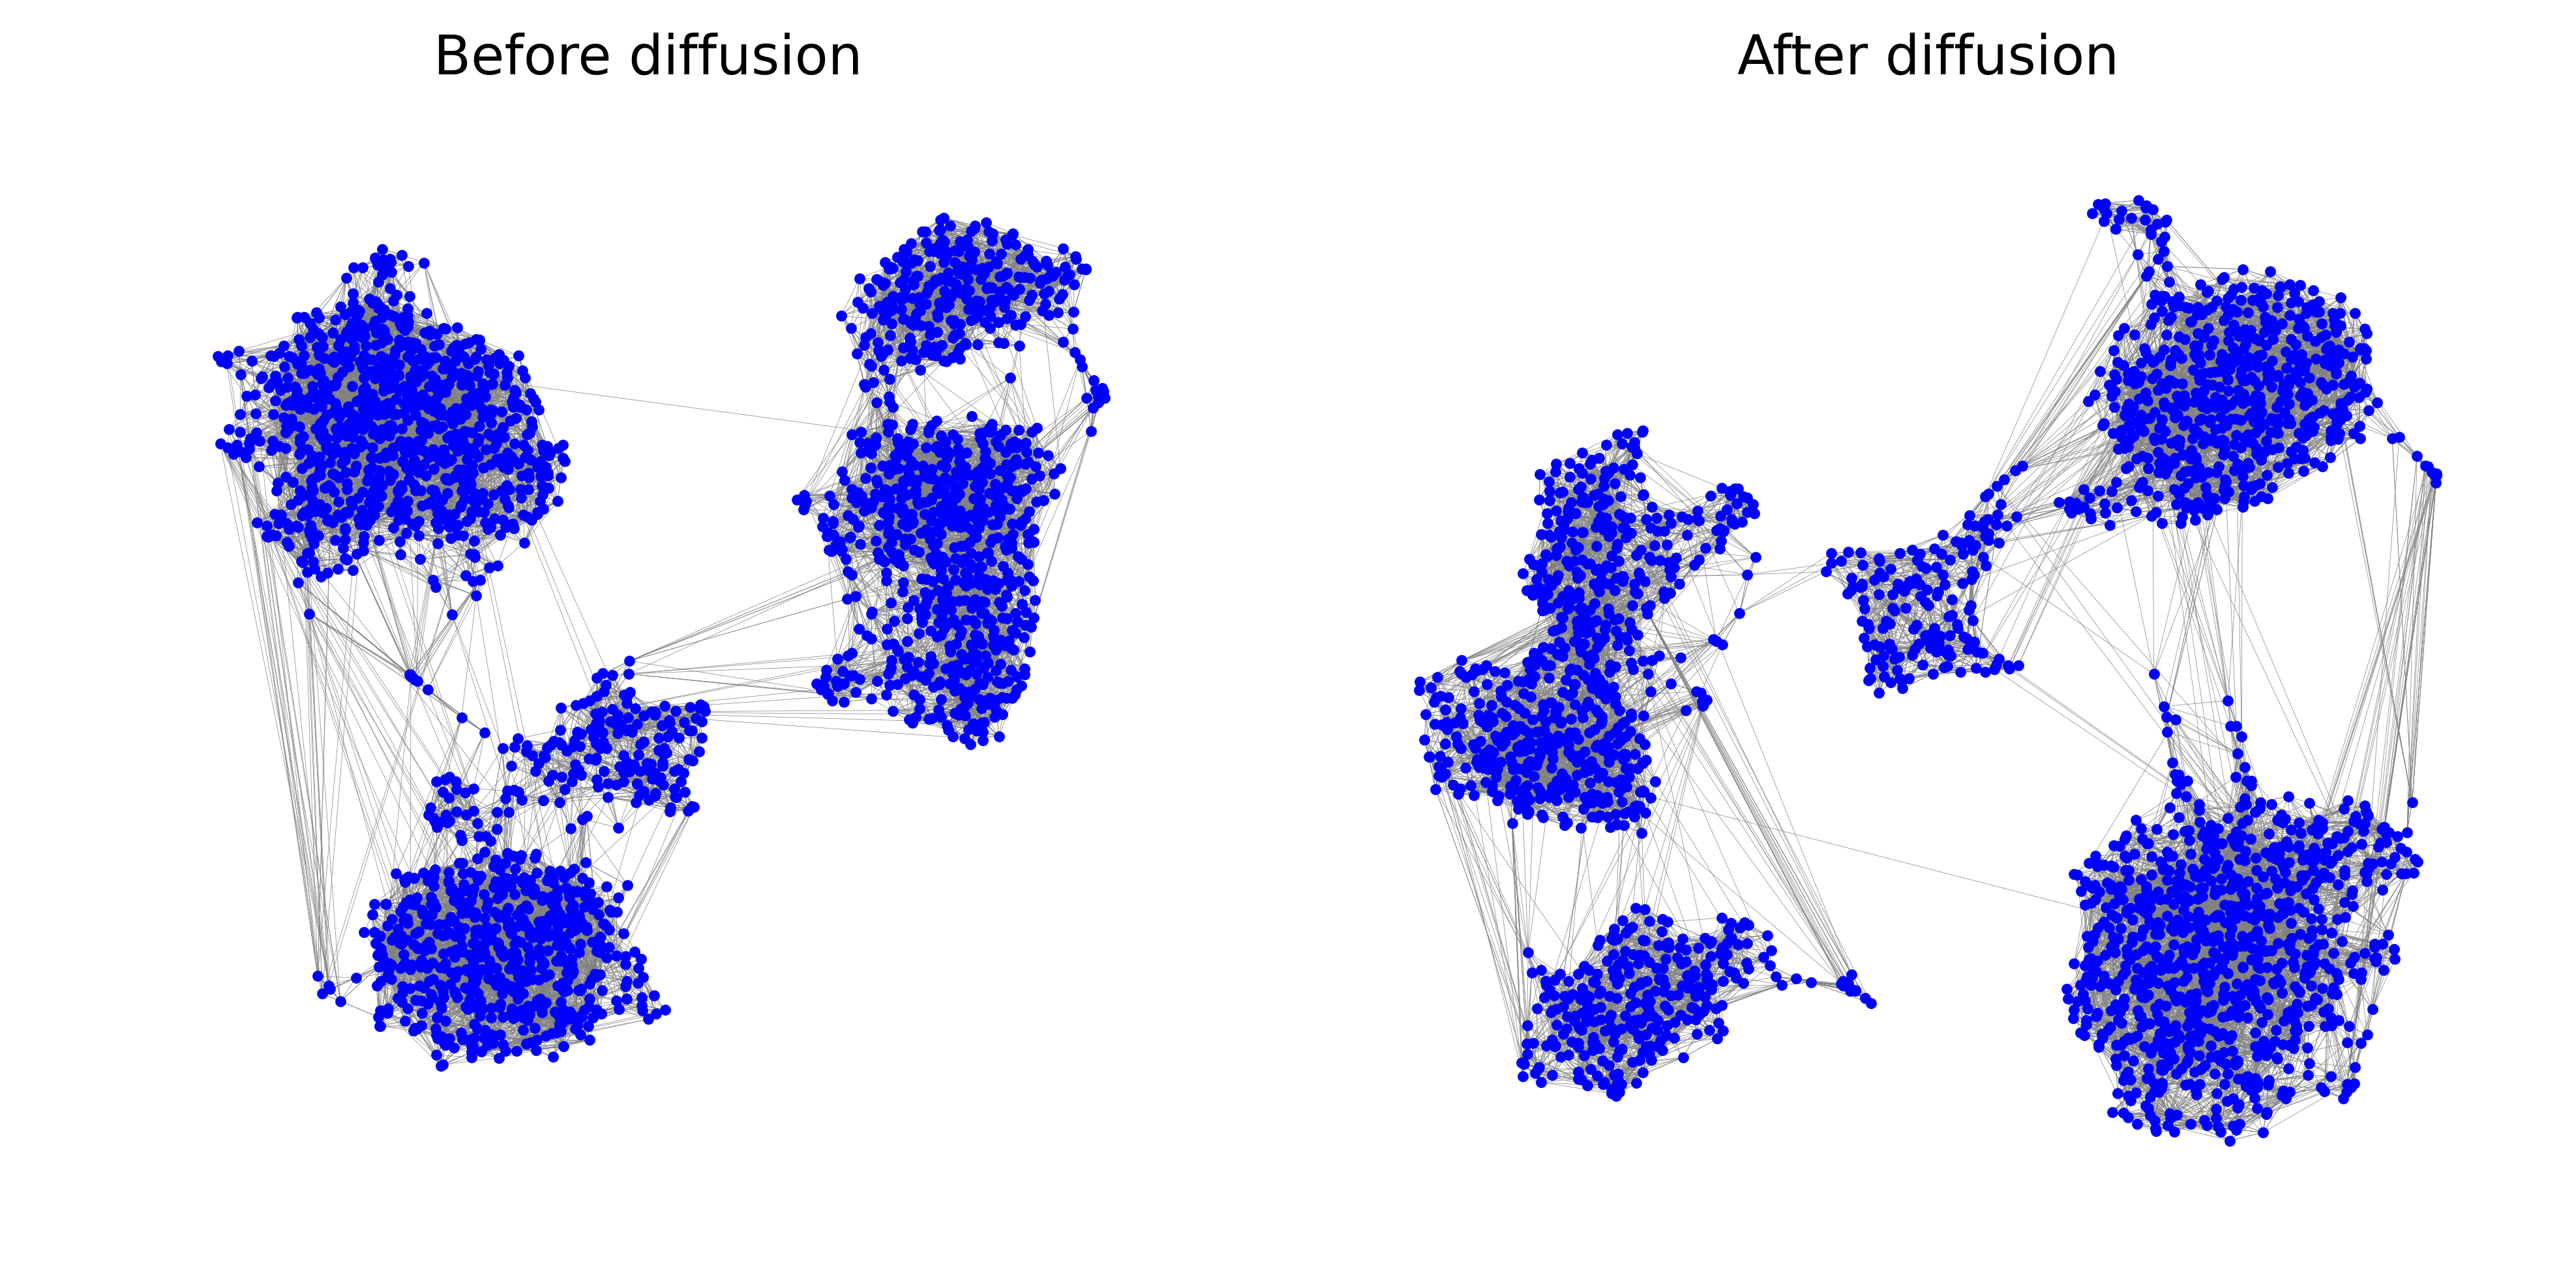

In [102]:
gnd_view(scdata, fig_size = (8,4), 
                   clusters=False, edges=True, 
                   edge_scale=0.1, node_scale=2, save_fig=None)

# umap_view(scdata, data='gae.output',clusters=False, edges=True, 
#           edge_scale=0.02, node_scale=0.5, save_fig=OUTPUT_PATH+'umap.png')

## Call cell-cell attentions

### Attention for scdata.graph

In [103]:
# build acdata.graph

scdata = build_graph(scdata, k=50, data_type="gae", graph_name='graph', self_edge = False, prune=False)

print("Total number of edges: ", scdata.graph.edge_index.shape[1])


Total number of edges:  135850


In [104]:
# Calculation attentions

scdata = call_attention(scdata, data_type="gae_output", use_graph="graph", distance_adjust=False)


In [105]:
#load attentions to edges of acdata.graph

scdata.graph.load_edge_attention(attention_type='adjusted_attention')


## Clustering

In [117]:
# Cell-cell attentions based clustering

scdata= clustering(scdata, use_graph="graph", resolution=0.21)

print("Total number of clusters: ", max(scdata.cluster)+1)
print(scdata.cluster)

#scdata.save(OUTPUT_PATH+"scdate_cluster.pickle")

Total number of clusters:  4
[0 0 0 ... 1 1 1]


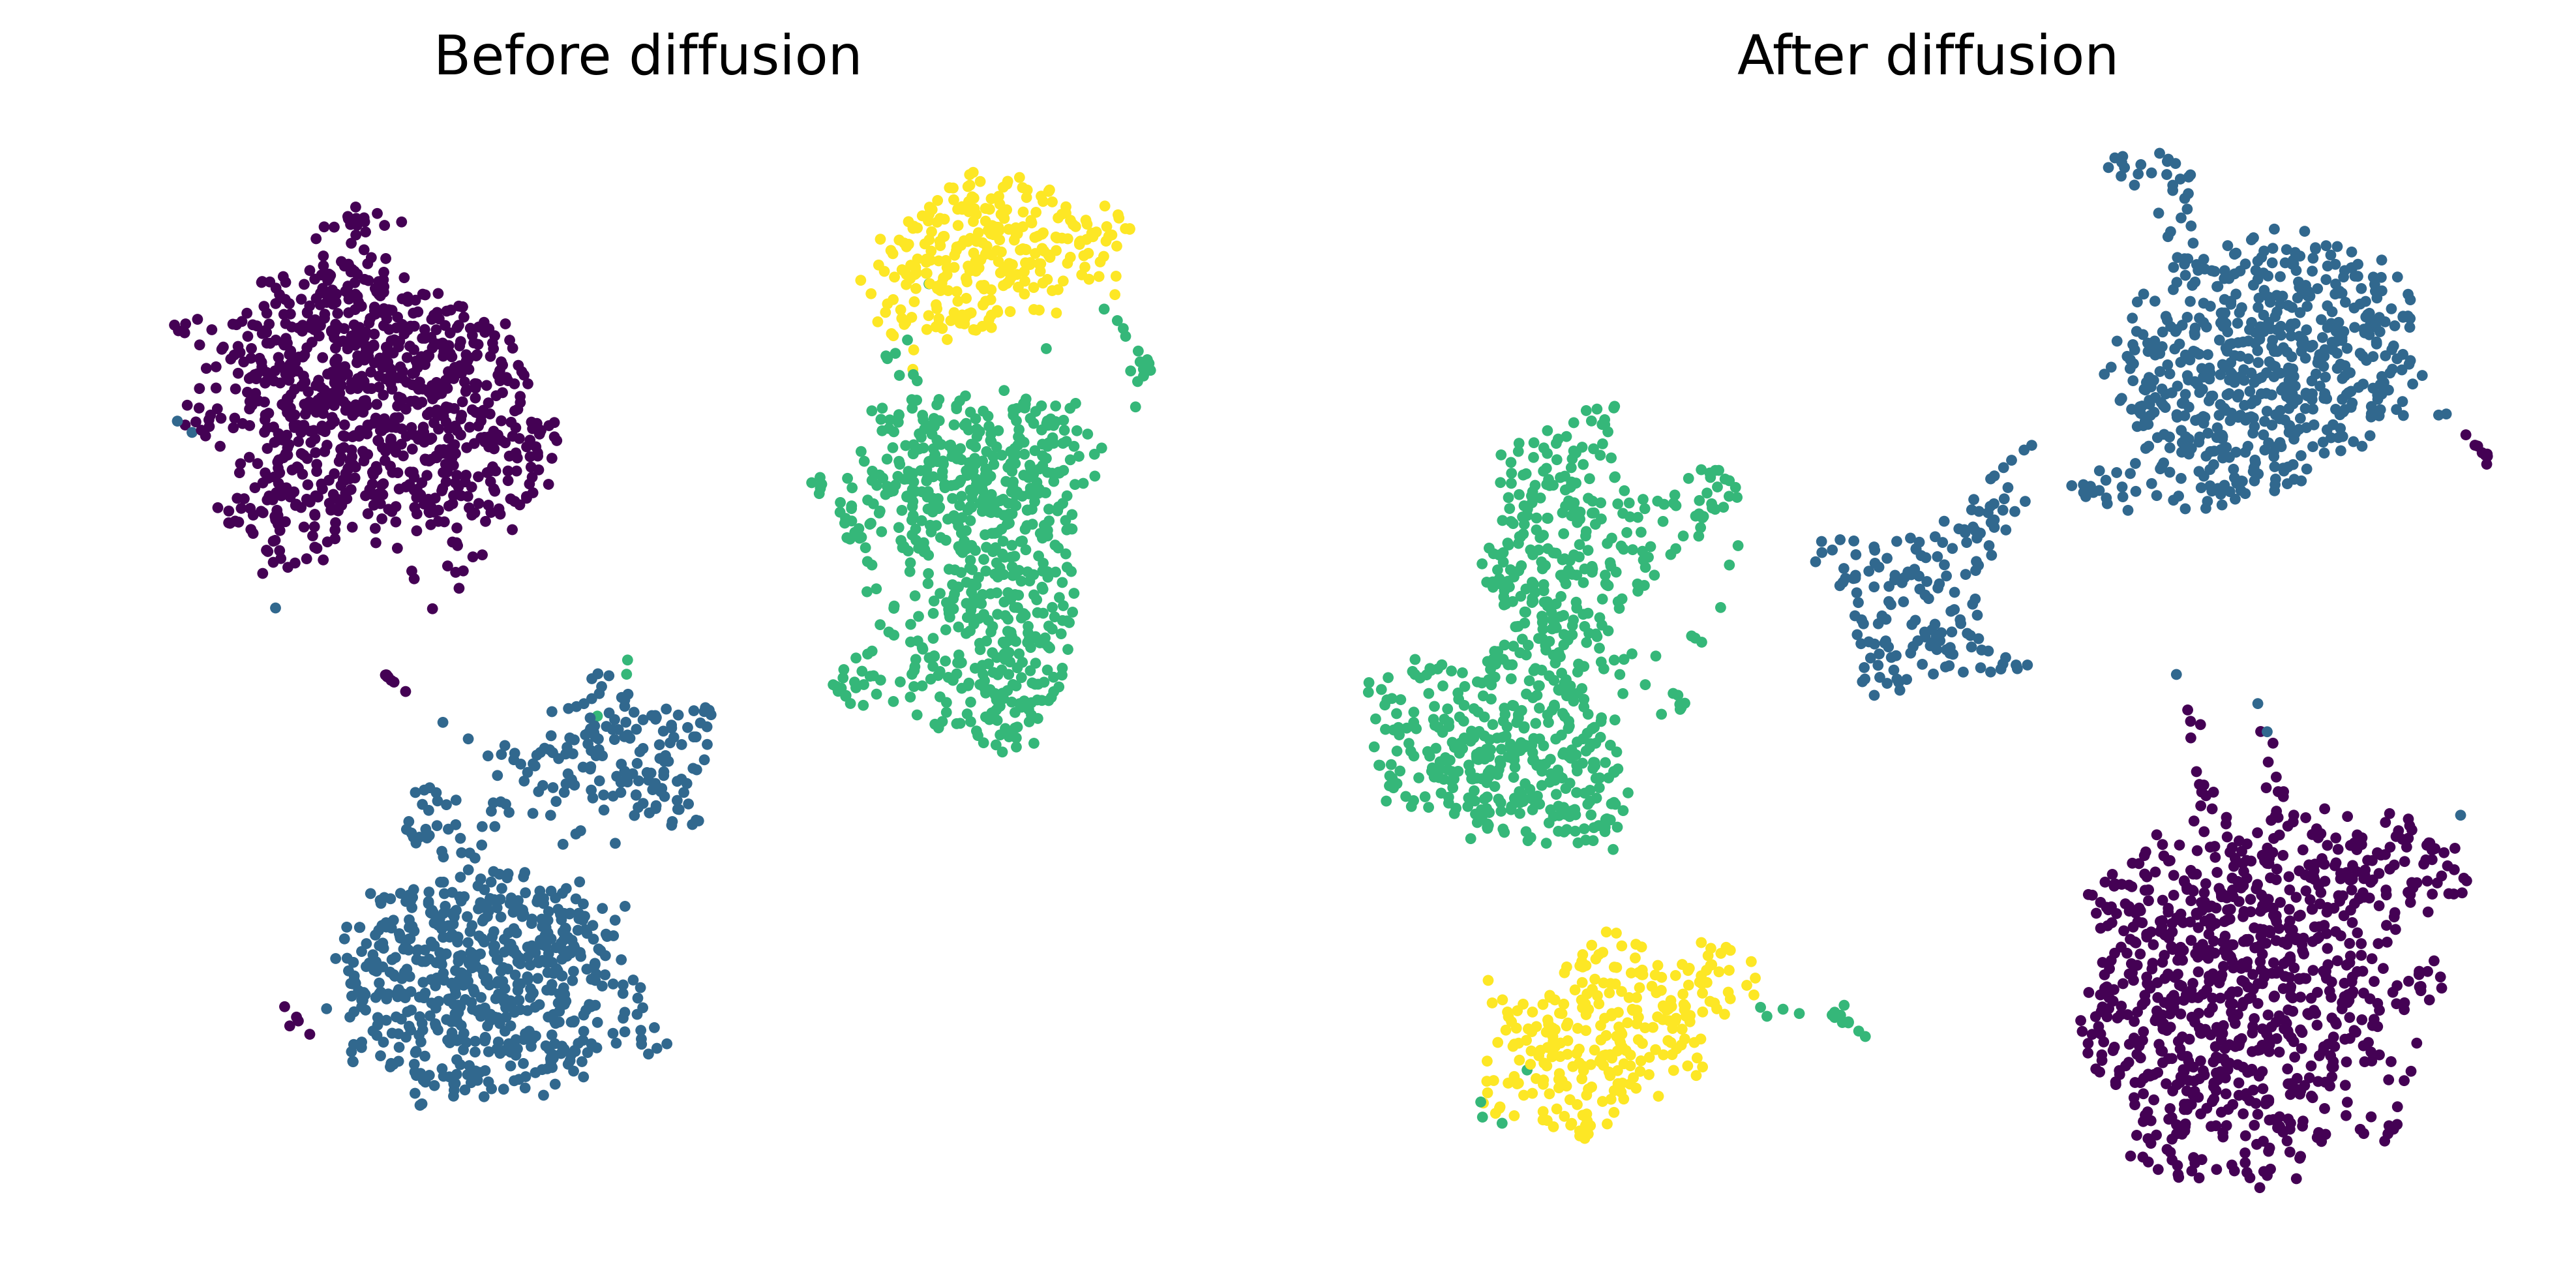

In [120]:
gnd_view(scdata, fig_size = (8,4), 
                   clusters=True, edges=False, 
                   edge_scale=0.1, node_scale=2, save_fig=OUTPUT_PATH+'clustering_scdif.png')


In [34]:
# Record cluster information

scdata = record_cluster(scdata)


## Load predefined clustering labels

In [10]:
import numpy
labels = numpy.loadtxt(DATA_PATH+"labels.csv", delimiter=",")
labels = labels.astype(int)
labels[labels==3] = 5
labels[labels==1] = 3
labels[labels==5] = 1
print(labels)
print(len(numpy.unique(labels)))
print(numpy.unique(labels))

[0 0 0 ... 1 1 1]
4
[0 1 2 3]


In [33]:
scdata.cluster = labels

## Compare clusters with real labels

In [118]:
evaluate_clustering(scdata.cluster, labels)

(0.9841832848519161, 0.9722638541758813, 0.9886260862501765)

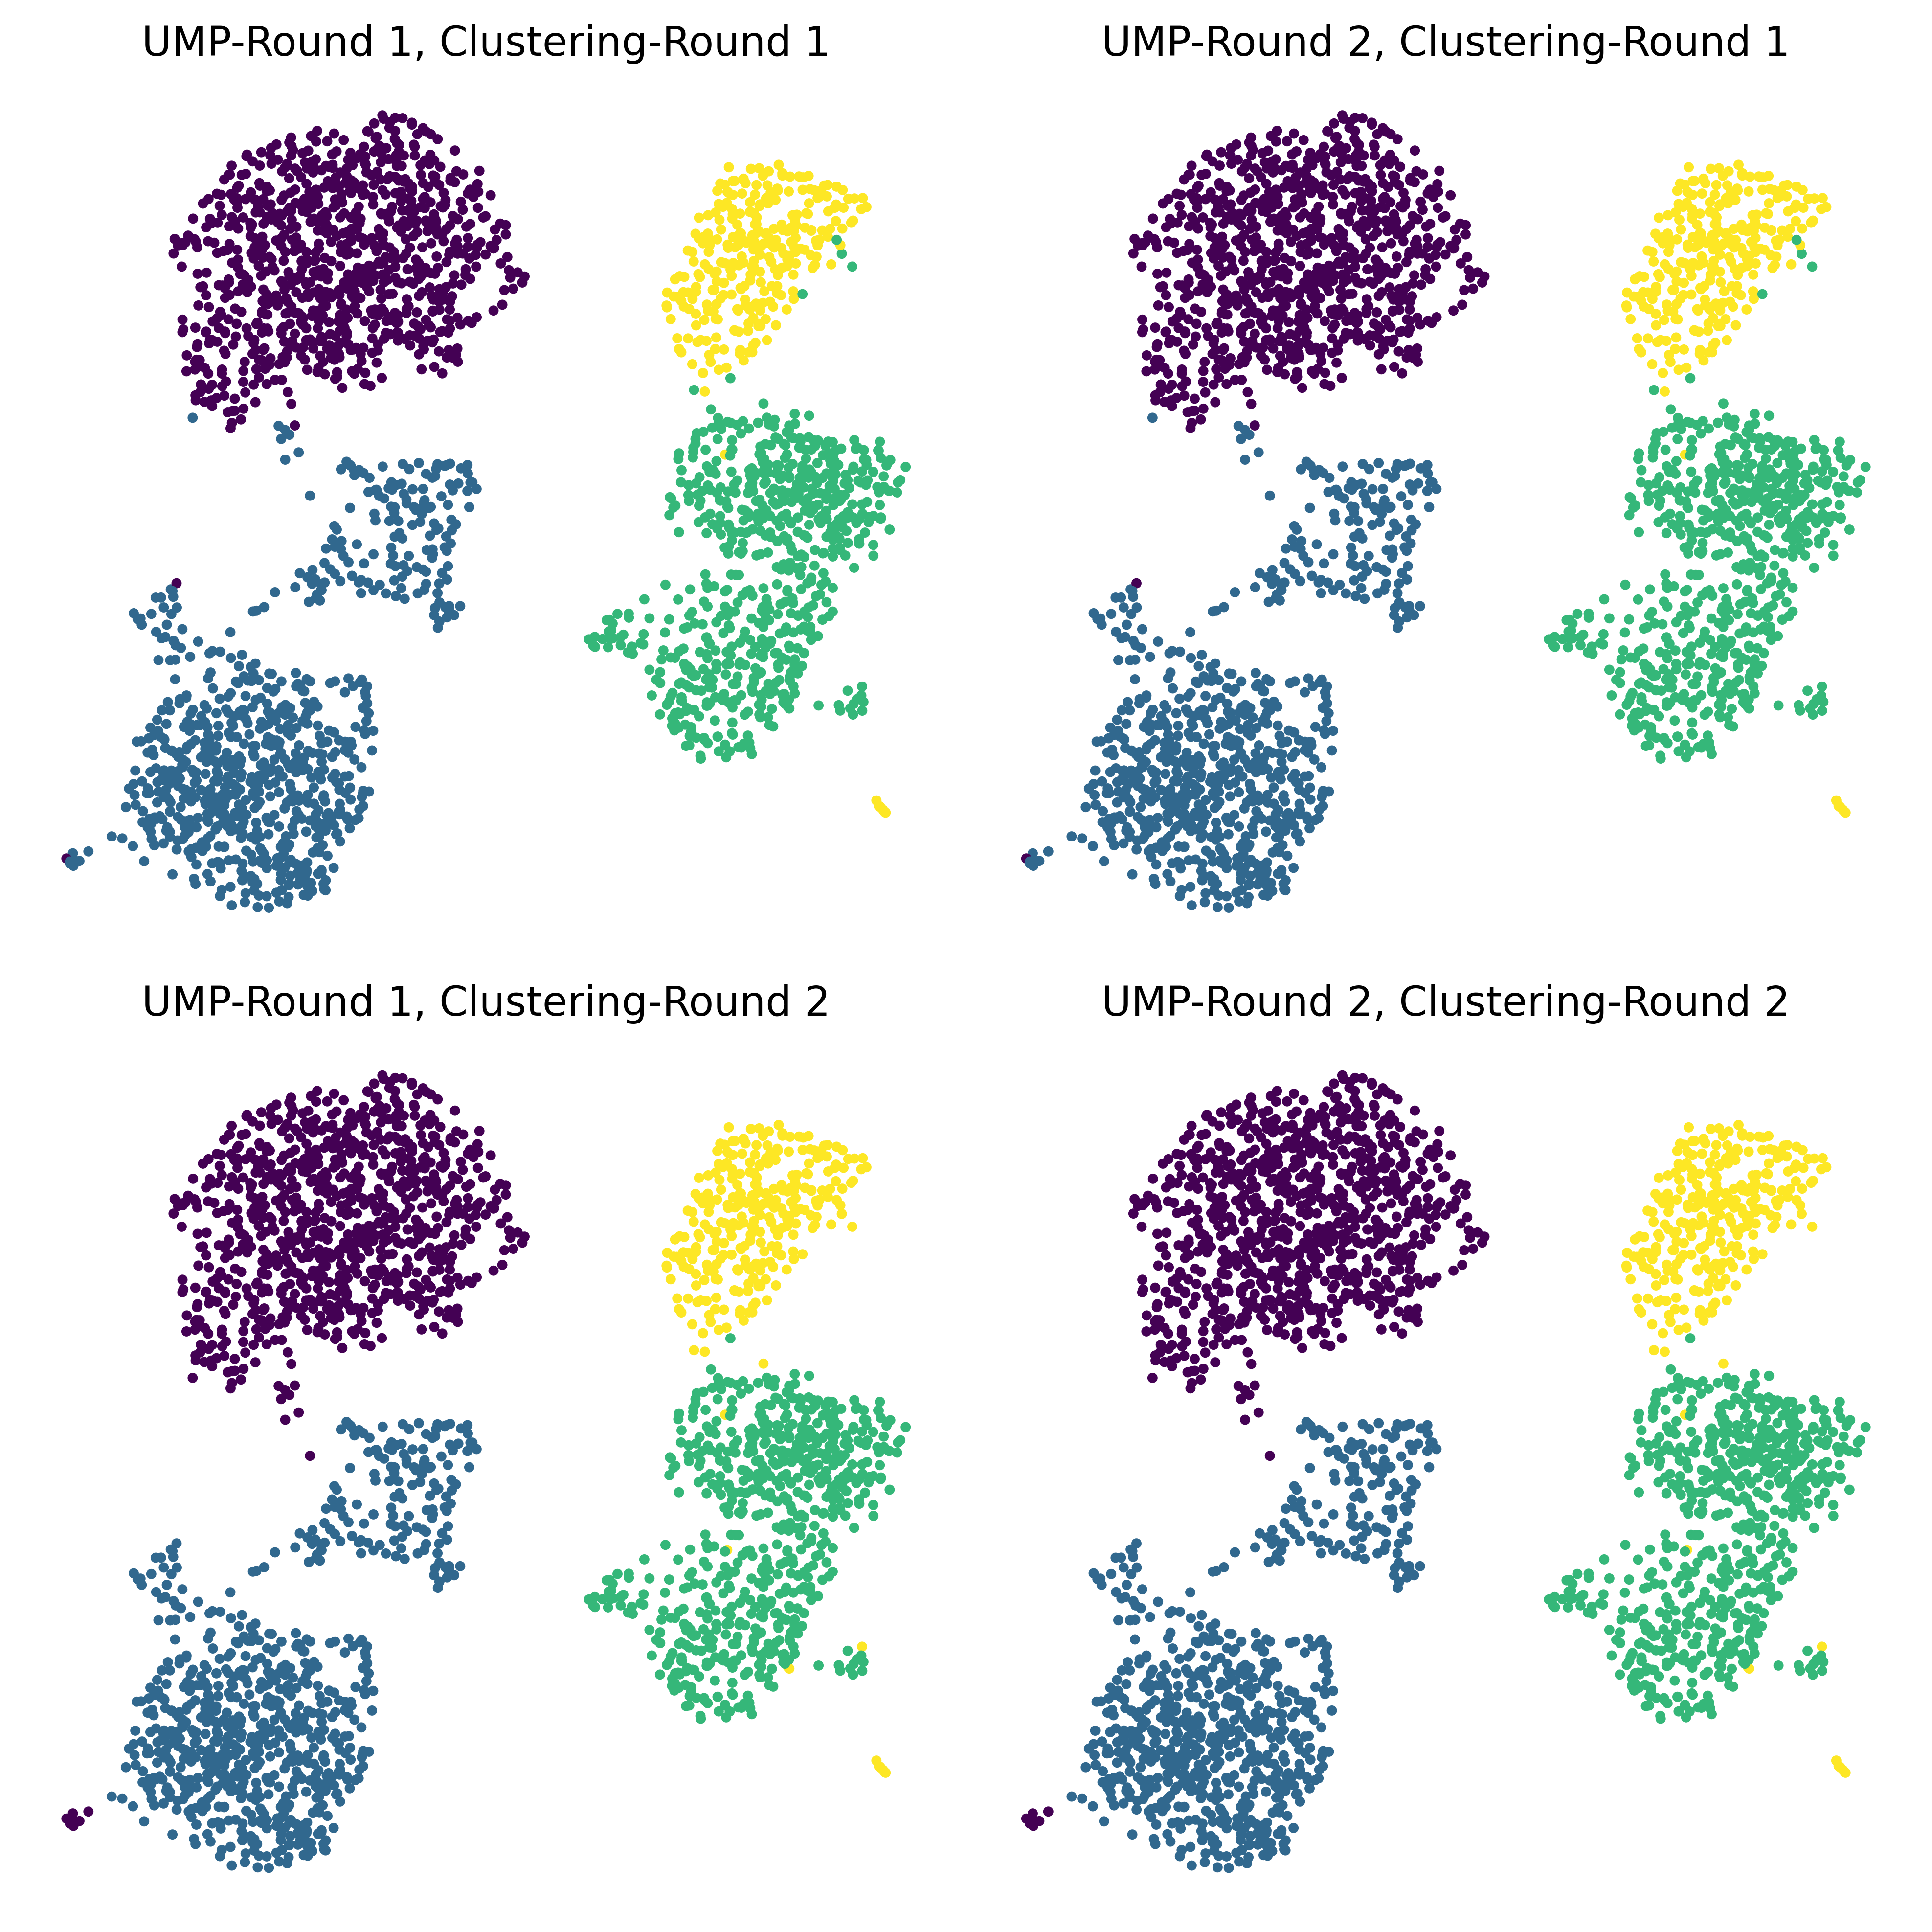

In [39]:
clustering_comparation_view(scdata, other=None, fig_size = (8,8), 
                                edges=False, edge_scale=0.05, node_scale=4, save_fig=None)

## Save scdata

In [119]:

scdata.save(OUTPUT_PATH+"scdata_cluster.pickle")


## Load scdata

In [6]:
scdata = SCData.load(OUTPUT_PATH+"scdata_cluster.pickle")